Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 516s 10s/step - accuracy: 0.9077 - dice_coef: 0.1964 - iou_score: 0.1650 - loss: 0.6747 - val_accuracy: 0.9547 - val_dice_coef: 0.2461 - val_iou_score: 0.2325 - val_loss: 0.2409 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 490s 9s/step - accuracy: 0.9640 - dice_coef: 0.2476 - iou_score: 0.2361 - loss: 0.1930 - val_accuracy: 0.9547 - val_dice_coef: 0.2525 - val_iou_score: 0.2366 - val_loss: 0.2112 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 502s 10s/step - accuracy: 0.9638 - dice_coef: 0.2550 - iou_score: 0.2395 - loss: 0.1695 - val_accuracy: 0.9547 - val_dice_coef: 0.2673 - val_iou_score: 0.2474 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 495s 10s/step - accuracy: 0.9583 - dice_coef: 0.2647 - iou_score: 0.2450 - loss: 0.1808 - val_accuracy: 0.9547 - v

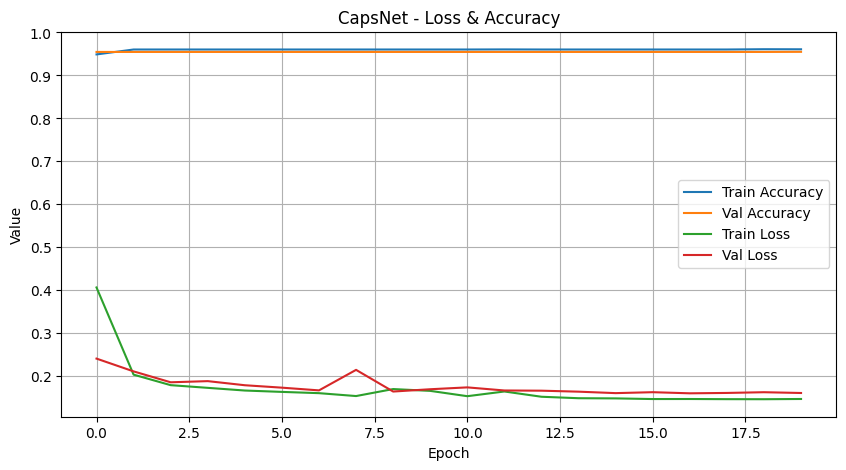

In [3]:
# Script: capsnet_training.py
# Purpose: Train a 3D CapsNet model using a data generator on sampled_128 (64x64x64)

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

# -------------------------------
# 1. MOUNT GOOGLE DRIVE
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/sampled_128"

# -------------------------------
# 2. DATA GENERATOR (DOWNSAMPLED)
# -------------------------------
class VolumeDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=1, shuffle=True):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.npy')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.npy')))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_img_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = [np.load(p).astype(np.float32)[::2, ::2, ::2, :] for p in batch_img_paths]
        masks = [np.load(p).astype(np.float32)[::2, ::2, ::2, :] for p in batch_mask_paths]

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(temp)
            self.image_paths, self.mask_paths = zip(*temp)

# -------------------------------
# 3. SQUASH FUNCTION
# -------------------------------
def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + 1e-7)
    return scale * vectors

# -------------------------------
# 4. CAPSNET MODEL (3D VERSION)
# -------------------------------
def capsnet_3d(input_shape=(64,64,64,3), n_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Initial conv layers
    x = layers.Conv3D(32, 5, activation='relu', padding='same')(inputs)
    x = layers.Conv3D(32, 3, activation='relu', padding='same')(x)

    # Capsule squash
    x = layers.Lambda(squash)(x)  # shape: (64, 64, 64, 32)

    # Final segmentation conv (no upsampling)
    x = layers.Conv3D(32, 3, padding='same', activation='relu')(x)

    # Output layer
    output = layers.Conv3D(n_classes, 1, activation='softmax')(x)

    model = models.Model(inputs, output)
    return model


# -------------------------------
# 5. METRICS
# -------------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth))

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    return tf.reduce_mean((intersection + smooth) / (union - intersection + smooth))

# -------------------------------
# 6. TRAINING
# -------------------------------
train_gen = VolumeDataGenerator(
    image_dir=os.path.join(data_path, 'train/images'),
    mask_dir=os.path.join(data_path, 'train/masks'),
    batch_size=1
)

val_gen = VolumeDataGenerator(
    image_dir=os.path.join(data_path, 'val/images'),
    mask_dir=os.path.join(data_path, 'val/masks'),
    batch_size=1
)

model = capsnet_3d(input_shape=(64,64,64,3), n_classes=4)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', dice_coef, iou_score])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    callbacks=callbacks)

# -------------------------------
# 7. EVALUATION + PLOT
# -------------------------------
final_metrics = model.evaluate(val_gen, verbose=0)
print(f"\nFinal Validation Metrics:")
print(f"Loss:         {final_metrics[0]:.4f}")
print(f"Accuracy:     {final_metrics[1]:.4f}")
print(f"Dice Coef:    {final_metrics[2]:.4f}")
print(f"IoU Score:    {final_metrics[3]:.4f}")

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CapsNet - Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
